In [1]:
import rdflib
import loader
import discourse
import pandas as pd
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass belongs to more than one entity types: [owl.ObjectProperty, datamodels_rdf.MetaProperty, datamodels_rdf.RelationshipProperties]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToClass belongs to more than one entity types: [owl.ObjectProperty, datamodels_rdf.MetaProperty, datamodels_rdf.RelationshipProperties]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains belongs to more than one entity types: [owl.ObjectProperty, owl.ObjectProperty, owl.ObjectProperty, datamodels_rdf.MetaProperty]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticw

datamodels_rdf.Mapping_Attribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_AttributeHasDataType [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Class [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ClassContainsAttribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Context [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ContextContainsClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ContextContainsSubContext [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_DomainContainsModel [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_FromAttribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_FromClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Model [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsContext [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsRelationship [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelDomain [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelHasModelT

* Owlready2 * HermiT took 0.6853220462799072 seconds
* Owlready * Reparenting datamodels_rdf.FactPredicate: {owl.ObjectProperty, datamodels_rdf.Contains} => {datamodels_rdf.Contains}
* Owlready * Reparenting datamodels_rdf.FactObject: {owl.ObjectProperty, datamodels_rdf.Contains} => {datamodels_rdf.Contains}
* Owlready * Reparenting datamodels_rdf.FactSubject: {owl.ObjectProperty, datamodels_rdf.Contains} => {datamodels_rdf.Contains}
* Owlready * Reparenting datamodels_rdf.RelationshipFromClass: {owl.ObjectProperty, datamodels_rdf.RelationshipProperties} => {datamodels_rdf.MetaProperty, datamodels_rdf.RelationshipProperties}
* Owlready * Reparenting datamodels_rdf.RelationshipFromOptionality: {owl.ObjectProperty, datamodels_rdf.RelationshipProperties} => {datamodels_rdf.RelationshipProperties}
* Owlready * Reparenting datamodels_rdf.RelationshipToAttribute: {owl.ObjectProperty, datamodels_rdf.RelationshipProperties} => {datamodels_rdf.MetaProperty, datamodels_rdf.RelationshipProperties

In [2]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from IPython.core.display import HTML


def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g


In [3]:

def nan2None(value):
    if pd.isnull(value) :
        return None
    else:
        return value


def get_data_rows(filename):
    data_rows_df = pd.read_csv(filename)
    data_rows=[]
    for i,r in data_rows_df.iterrows():
        r_d = {k:nan2None(v) for k,v in dict(r).items()}

        data_rows.append(r_d)
    del data_rows_df
    return data_rows


In [4]:
serial_key = { "Business Domain" : "ModelDomain", 
               "Model" : "Model", 
               "ModelType" : "ModelType", 
               "Entity" : "Class", 
               "Attribute" : "Attribute", 
               "DataType" : "DataType", 
               "Context" : "Context", 
               "SubContext" : "SubContext", 
               "Relationship" : "Relationship", 
               "Entity From" : "FromClass",
               "Attribute From" : "FromAttribute", 
               "Cardinality From" : "FromCardinality",
               "Entity To" : "ToClass",
               "Attribute To" : "ToAttribute",
               "Cardinality To" : "ToCardinality"
}

# job_def is in the form (Serialization, key, data )
job_def_load_entities = ("Model Load", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("model_entities.csv")  )
batch_manifest = [job_def_load_entities]

In [5]:
# Create Empty Graph
test = Graph()
test.parse ("datamodels_rdf.owl", format='xml')
test.parse ("discourse.owl", format='xml')
dmns = Namespace(loader.onto.base_iri)
test.bind('dm', dmns, override=True, replace=True)
discns = Namespace(discourse.onto.base_iri)
test.bind('disc', discns, override=True, replace=True)

test.bind('rdfs', RDFS)
#namespace_d = {'dm': dmns, 'rdfs' : RDFS, 'rdf' : RDF}

In [6]:
qtest = loader.load_data("Model Entities", batch_manifest=batch_manifest, rdflib_graph=test)

In [7]:

data_load_objects_sparql = """
SELECT (count(?s) as ?count) ?t
WHERE 
    {
        ?s a ?t .
    }
GROUP BY ?t
"""
results = qtest.query(data_load_objects_sparql)

In [8]:
sorted(filter(lambda f: any([x in f[0] for x in ["discourse", "datamodel"]]),[("/".join(r[1].toPython().split("/")[-1:]), r[0].toPython())  for r in results]), key=lambda x: x[1])[::-1]


[('discourse#Declaration', 360),
 ('discourse#Posit', 128),
 ('datamodel#Mapping', 26),
 ('discourse#Discourse', 22),
 ('datamodel#RowNode', 20),
 ('datamodel#Attribute', 14),
 ('datamodel#MetaProperty', 6),
 ('datamodel#MetaDataProperty', 6),
 ('datamodel#MetaClass', 6),
 ('datamodel#Class', 4),
 ('datamodel#Relationship', 3),
 ('datamodel#Serialization', 2),
 ('datamodel#Context', 2),
 ('datamodel#ModelDomain', 1),
 ('datamodel#BatchNode', 1),
 ('datamodel#JobNode', 1),
 ('datamodel#Model', 1)]

In [9]:
job_def_load_entities = ("Entity Load 2", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("model_entities_v2.csv")  )
batch_manifest = [job_def_load_entities]
qtest = loader.load_data("test_v2", batch_manifest=batch_manifest, rdflib_graph=qtest)


In [10]:

data_load_objects_sparql = """
SELECT (count(?s) as ?count) ?t
WHERE 
    {
        ?s a ?t .
    }
GROUP BY ?t
"""
results = qtest.query(data_load_objects_sparql)
sorted(filter(lambda f: any([x in f[0] for x in ["discourse", "datamodel"]]),[("/".join(r[1].toPython().split("/")[-1:]), r[0].toPython())  for r in results]), key=lambda x: x[1])[::-1]



[('discourse#Declaration', 648),
 ('discourse#Posit', 133),
 ('discourse#Discourse', 41),
 ('datamodel#RowNode', 37),
 ('datamodel#Mapping', 26),
 ('datamodel#Attribute', 15),
 ('datamodel#MetaProperty', 6),
 ('datamodel#MetaClass', 6),
 ('datamodel#MetaDataProperty', 6),
 ('datamodel#Class', 4),
 ('datamodel#Relationship', 3),
 ('datamodel#Serialization', 2),
 ('datamodel#JobNode', 2),
 ('datamodel#BatchNode', 2),
 ('datamodel#Context', 2),
 ('datamodel#Model', 1),
 ('datamodel#ModelDomain', 1)]

In [11]:
q="""SELECT ?batch_node ?batch_name
WHERE {
    ?batch_node a dm:BatchNode.
    ?batch_node dm:Name ?batch_name
}"""
batch_nodes = list(qtest.query(q))
batch_nodes

[(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/371cf50b899d43faa37aec5858a35690'),
  rdflib.term.Literal('Model Entities')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/40dd8515d77d4eada21dd194b0314195'),
  rdflib.term.Literal('test_v2'))]

In [12]:
# Retrieve s,p,o digests from declared posits linked to individual data loads. 

discourse_q = """       SELECT ?digest
                        WHERE 
                            {
                                BIND (%%bn%% as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }
                        """

qq = discourse_q.replace("%%bn%%", batch_nodes[0][0].n3())
print(qq)
results = qtest.query(qq)
b_0_results = set(results)
print(len(b_0_results))

qq = discourse_q.replace("%%bn%%", batch_nodes[1][0].n3())
print(qq)
results = qtest.query(qq)
b_1_results = set(results)
print(len(b_1_results))
#visualize(t2rdflibg(results))

       SELECT ?digest
                        WHERE 
                            {
                                BIND (<http://www.semanticweb.org/tomk/ontologies/2022/9/371cf50b899d43faa37aec5858a35690> as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }
                        
128
       SELECT ?digest
                        WHERE 
                            {
                                BIND (<http://www.semanticweb.org/tomk/ontologies/2022/9/40dd8515d77d4eada21dd194b0314195> as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:M

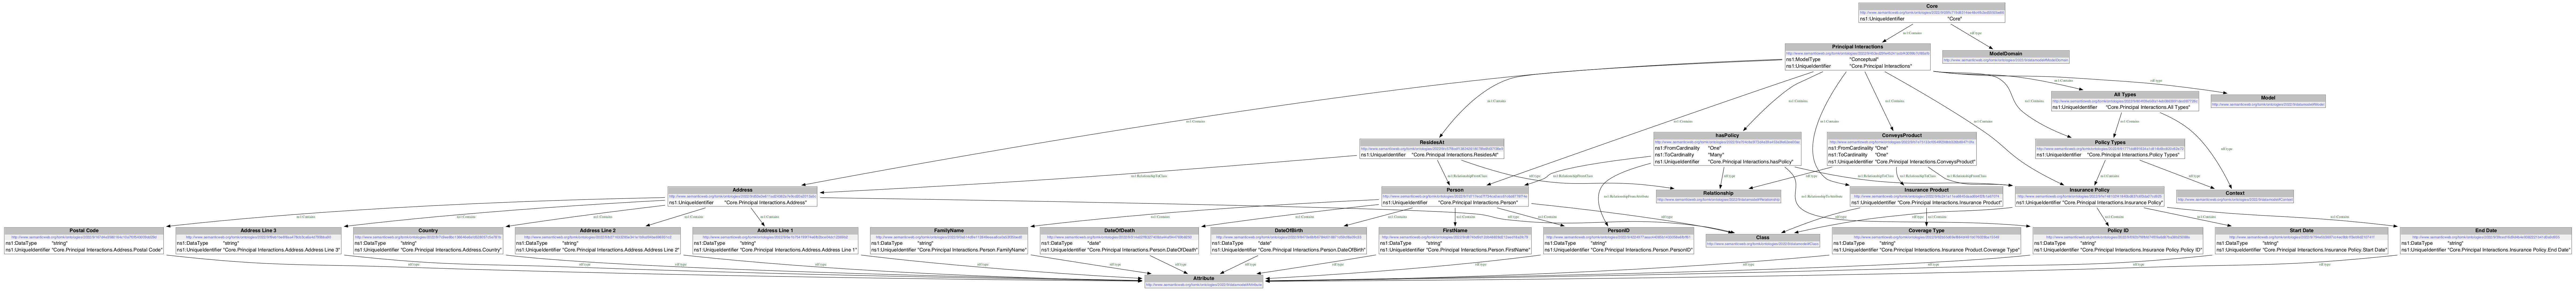

In [13]:

r_triples_0=[discourse.longform_to_triple(r[0]) for r in b_0_results]
visualize(t2rdflibg(r_triples_0))

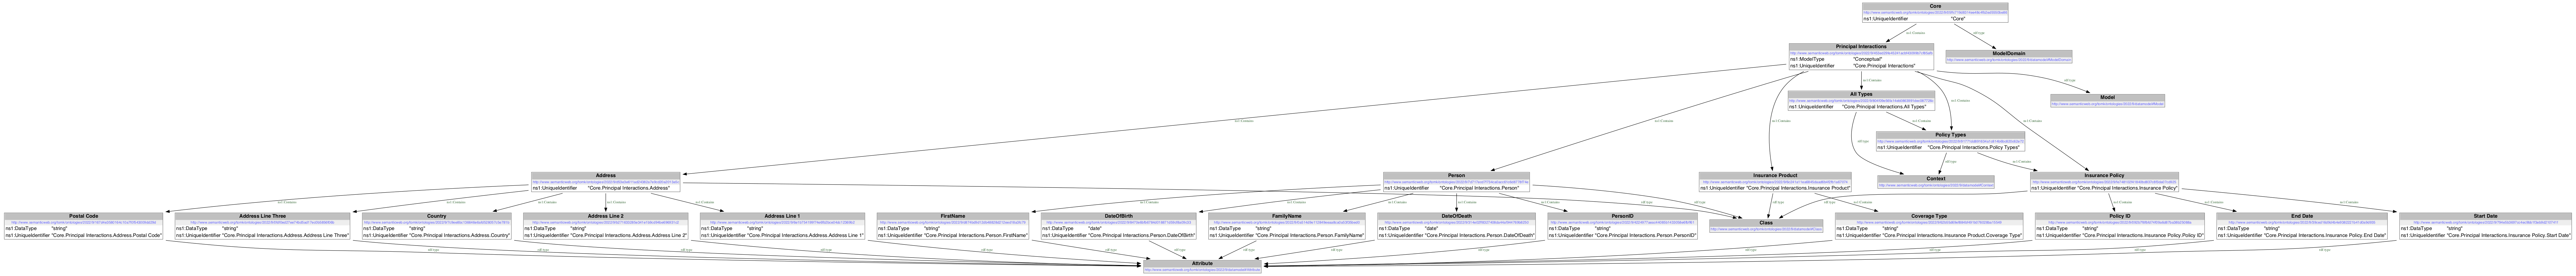

In [14]:
r_triples_1=[discourse.longform_to_triple(r[0]) for r in b_1_results]
visualize(t2rdflibg(r_triples_1))

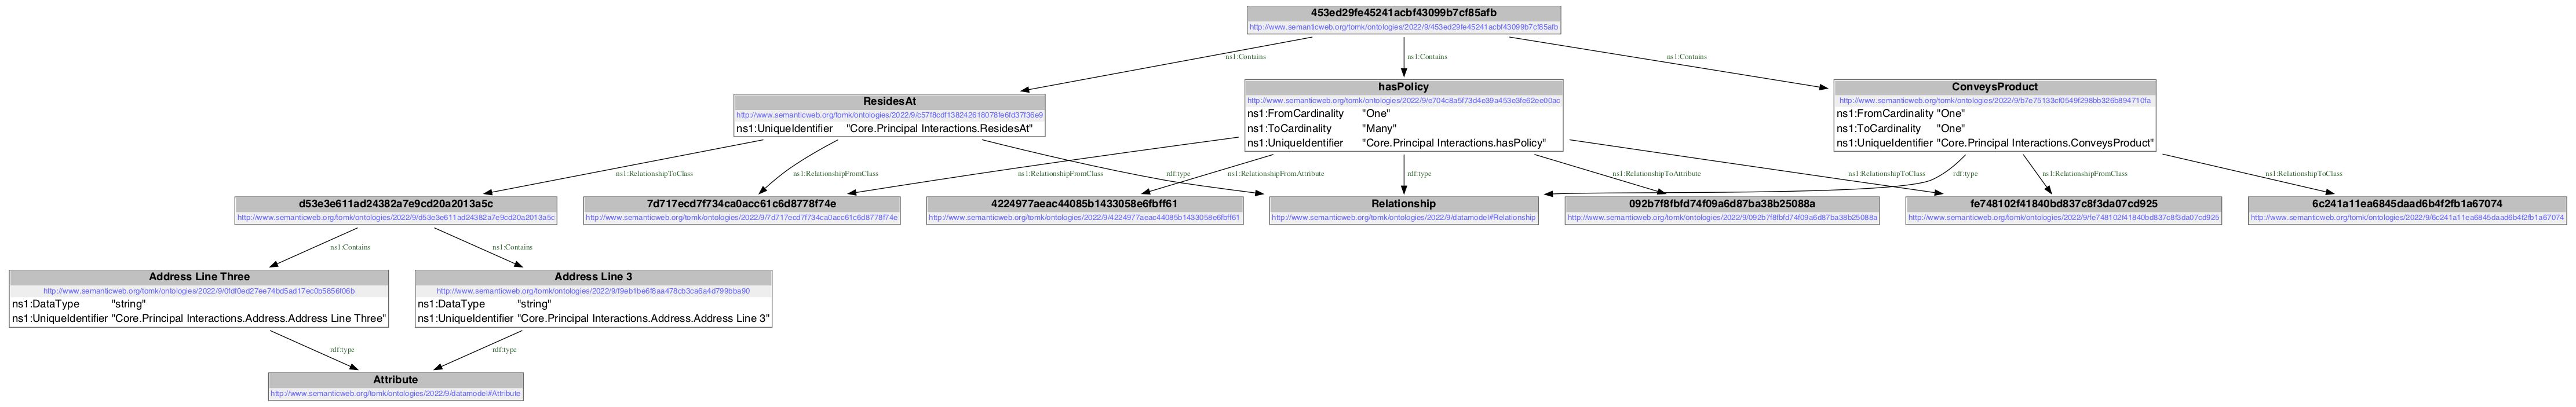

In [15]:
visualize(t2rdflibg(set(r_triples_0).symmetric_difference(set(r_triples_1))))

In [16]:
job_def_load_entities = ("Entity Load 3", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("sample/db_entities.csv")  )
batch_manifest = [job_def_load_entities]
qtest = loader.load_data("sample database", batch_manifest=batch_manifest, rdflib_graph=qtest)


In [17]:
batch_nodes = list(qtest.query(q))
batch_nodes

[(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/da9232e05d284fbbbecdb0bd5748f0e0'),
  rdflib.term.Literal('sample database')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/40dd8515d77d4eada21dd194b0314195'),
  rdflib.term.Literal('test_v2')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/371cf50b899d43faa37aec5858a35690'),
  rdflib.term.Literal('Model Entities'))]

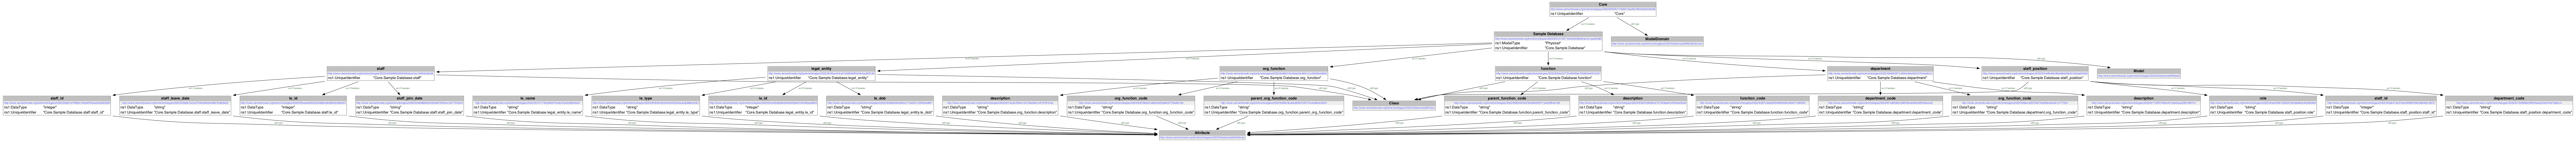

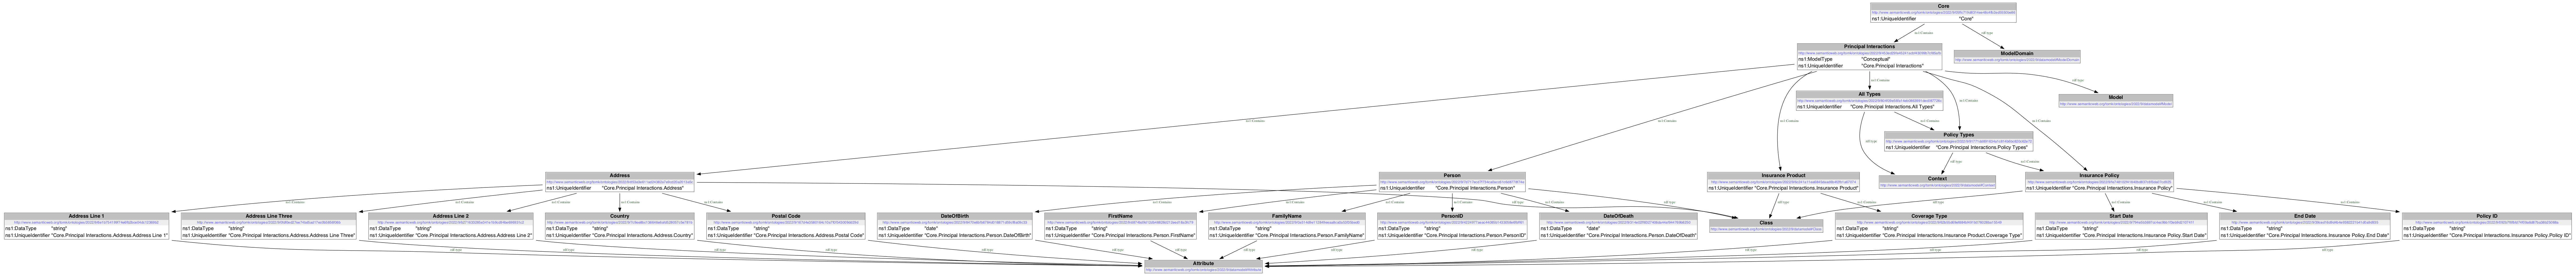

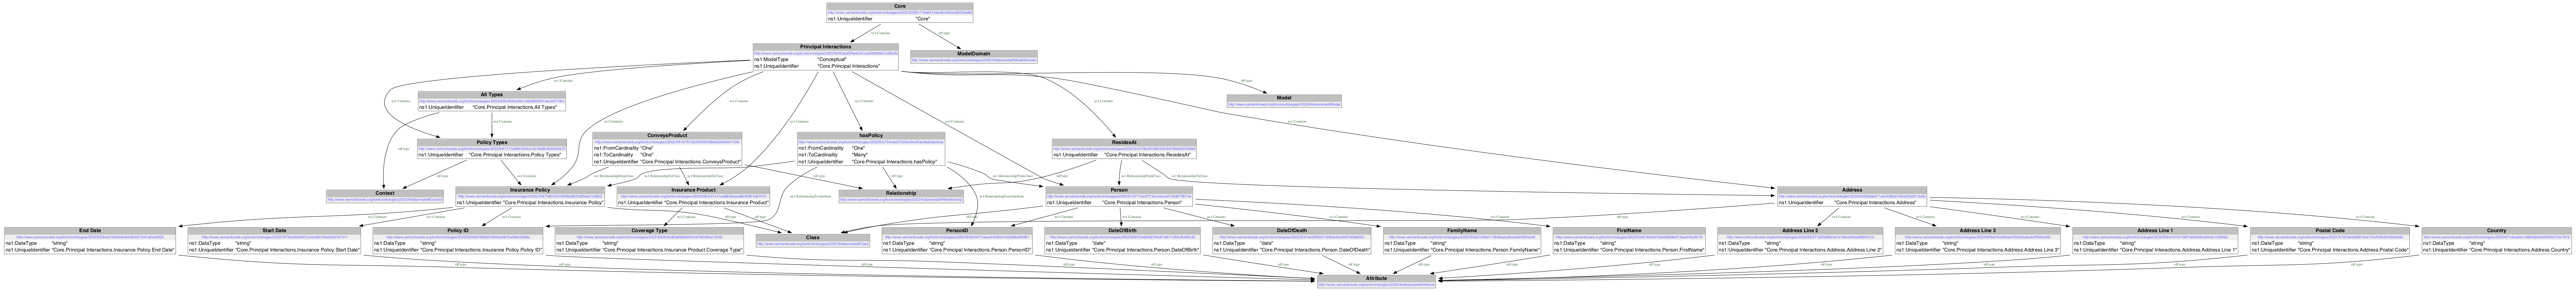

In [18]:
batch_triples=[]
for e,n in enumerate(batch_nodes):
    qq = discourse_q.replace("%%bn%%", n[0].n3())
    results = qtest.query(qq)
    batch_triples.append([discourse.longform_to_triple(r[0]) for r in results])
    visualize(t2rdflibg(batch_triples[e]))

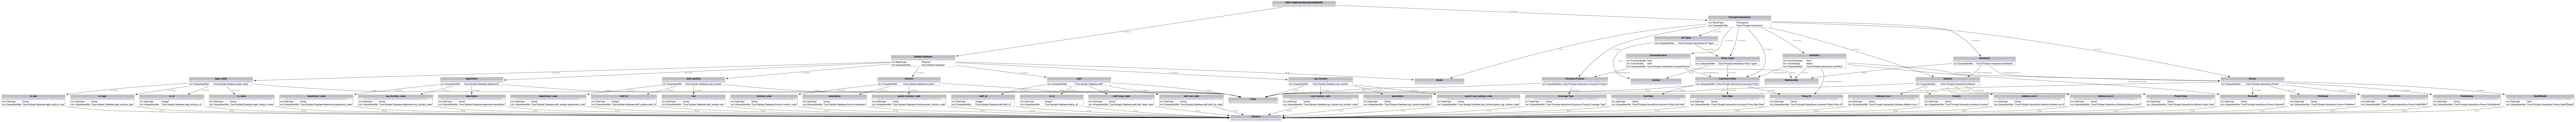

In [19]:
visualize(t2rdflibg(set(batch_triples[0]).symmetric_difference(set(batch_triples[2]))))

In [20]:
# ToDo: Create a set of relationship data for these sample datasets that can be uploaded as part of a batch
# This will demonstrate how multiple datasets/types can be uploaded under the same "batch" header.
# Enabling a fully defined model to be defined and compared against another model. 

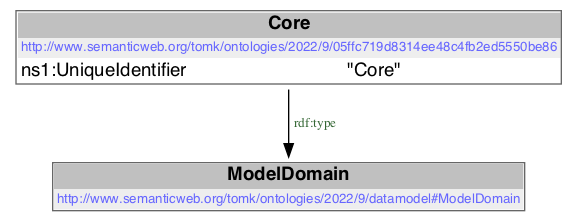

In [21]:
visualize(t2rdflibg(set(batch_triples[0]).intersection(set(batch_triples[2]))))

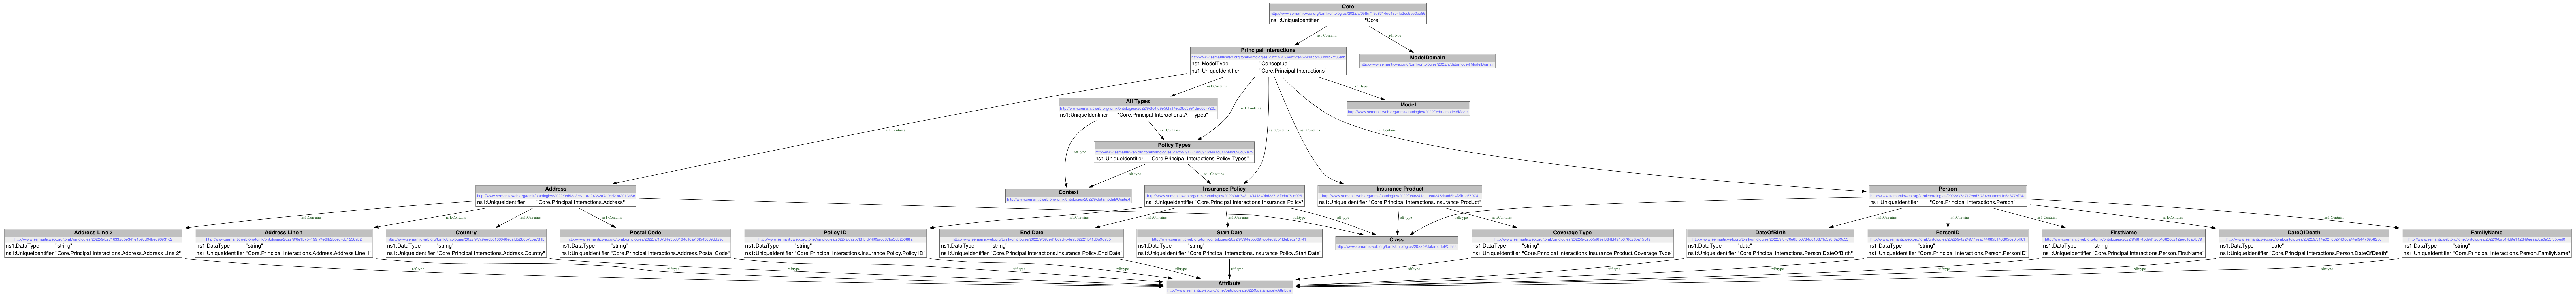

In [22]:
# Intersection of contents shows common values (no change between updates)
visualize(t2rdflibg(set(batch_triples[1]).intersection(set(batch_triples[2]))))

Remove


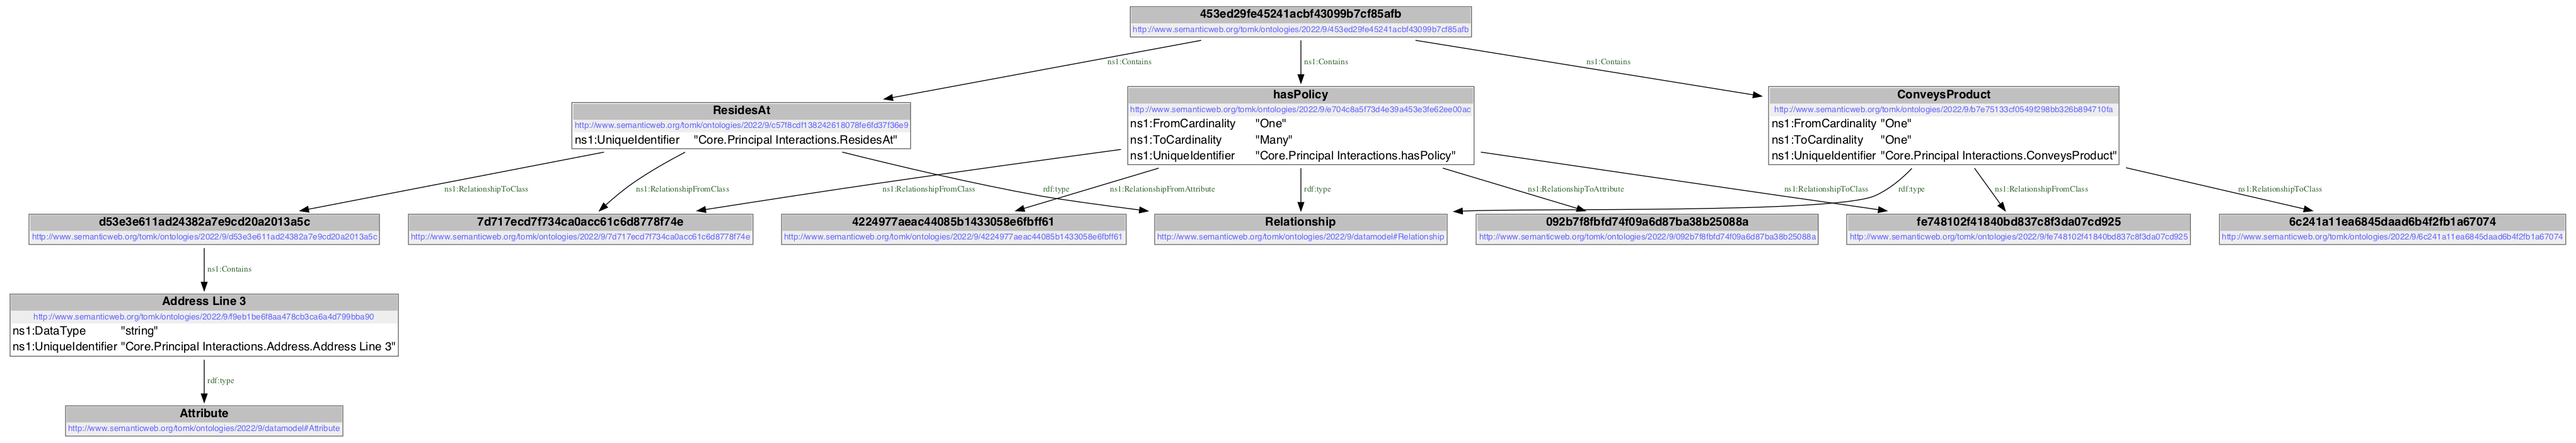

Add


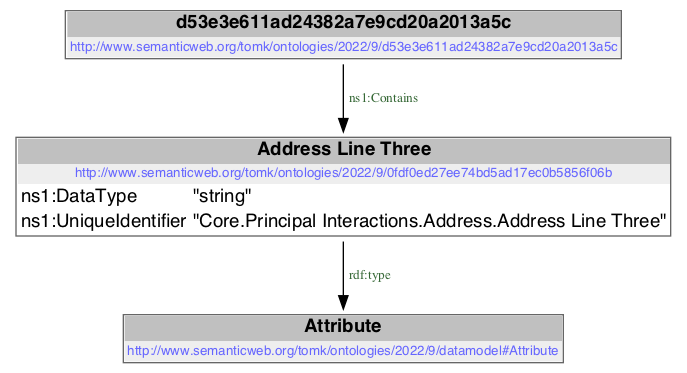

In [23]:
print("Remove")
visualize(t2rdflibg(set(batch_triples[2]).difference(set(batch_triples[1]))))
print("Add")
visualize(t2rdflibg(set(batch_triples[1]).difference(set(batch_triples[2]))))

In [24]:
# Using a Batch Identifier as a key, pull content from the database that represents
# one of the loaded models, and render an entity diagram showing models, entities, contexts
# classes, attributes and relationships.
q="""SELECT ?batch_node
WHERE {
    ?batch_node a dm:BatchNode.
    ?batch_node dm:Name ?batch_name
}"""
b_name = 'Model Entities'
# Bind an external value to the query using 'initBindings' dictionary
batch_nodes = list(qtest.query(q, initBindings={"batch_name": rdflib.Literal(b_name)}))
b_n = batch_nodes[0]
discourse_q = """       SELECT ?digest
                        WHERE 
                            {
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }
                        """
results = qtest.query(qq, initBindings={"batch_node": b_n[0]})
batch_triples = [discourse.longform_to_triple(r[0]) for r in results]

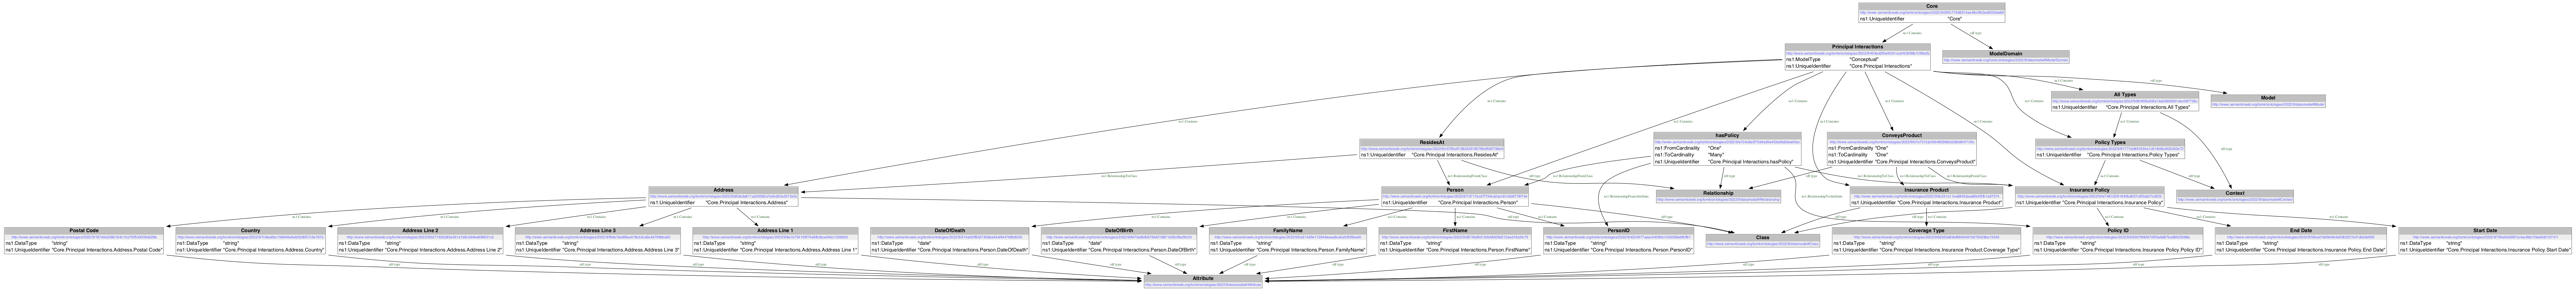

In [25]:
visualize(t2rdflibg(batch_triples))

In [26]:
test = Graph()
test.parse ("datamodels_rdf.owl", format='xml')
test.parse ("discourse.owl", format='xml')
dmns = Namespace(loader.onto.base_iri)
test.bind('dm', dmns, override=True, replace=True)
discns = Namespace(discourse.onto.base_iri)
test.bind('disc', discns, override=True, replace=True)

test.bind('rdfs', RDFS)
for t in batch_triples:
    test.add(t)

In [27]:
#visualize(t2rdflibg(test))

In [28]:
q = """       SELECT ?s  ?p ?o
                        WHERE 
                            {
                                ?s dm:ClassToClassRelationship ?o .
                            }
                        """
results = test.query(q)

In [29]:
list(results)

[]

In [30]:
q = """       SELECT ?s ?p ?o
                        WHERE 
                        {
                            {
                                ?s ^dm:RelationshipFromClass/dm:RelationshipToClass  ?o .
                                ?r dm:RelationshipToClass ?o.
                                ?r rdfs:label ?rl .
                                ?r a dm:Relationship .
                                BIND (?rl as ?p)
                            }
                            UNION
                            {
                                ?q ^dm:RelationshipFromClass/dm:RelationshipToClass ?s .
                                ?s rdfs:label ?o .
                                BIND (rdfs:label as ?p).
                                
                            }
                            UNION
                            {
                                ?s ^dm:RelationshipFromClass/dm:RelationshipToClass ?q .
                                ?s rdfs:label ?o .
                                BIND (rdfs:label as ?p).
                            }
                            
                            UNION
                            
                            {
                                ?s ^dm:RelationshipFromClass/dm:RelationshipToClass ?q .
                                ?s dm:Contains ?a .
                                ?a rdfs:label ?o .
                                BIND (dm:Attribute as ?p) .
                            }

                            UNION
                            
                            {
                                ?q ^dm:RelationshipFromClass/dm:RelationshipToClass ?s .
                                ?s dm:Contains ?a .
                                ?a rdfs:label ?o .
                                BIND (dm:Attribute as ?p) .
                            }



                            }
                        """
results = test.query(q)

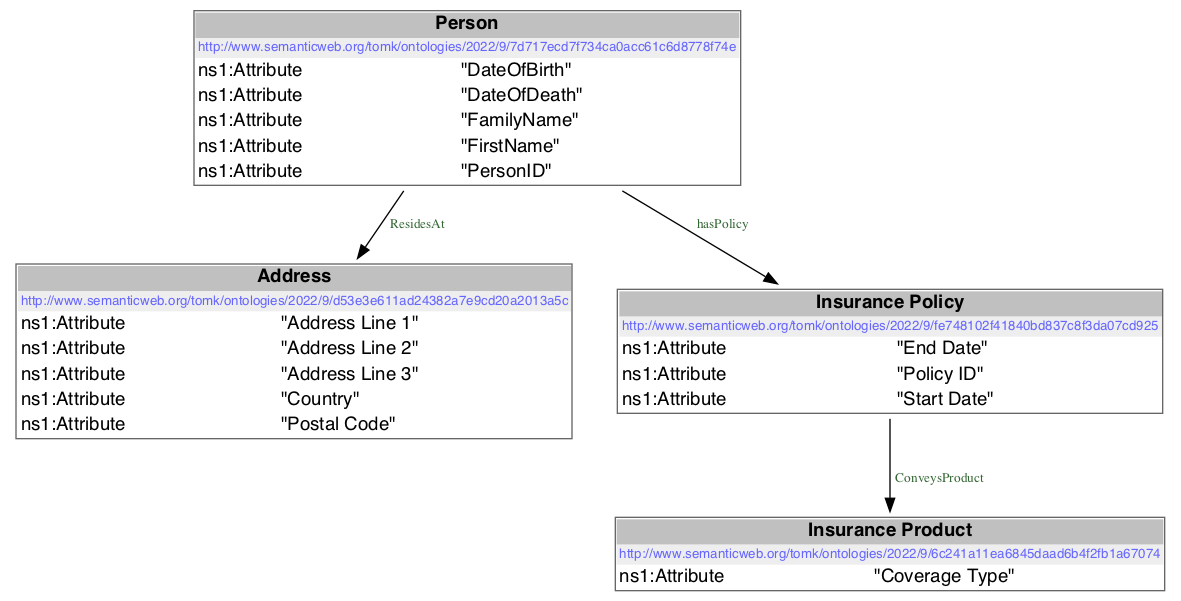

In [31]:
# Cheap Entity/Attribute (Conceptual/Logical) Diagram
visualize(t2rdflibg(results))

In [32]:
g=t2rdflibg(results)
stream = io.StringIO()
rdf2dot(g, stream, opts = {display})
dg = pydotplus.graph_from_dot_data(stream.getvalue())

In [33]:
dg

In [185]:
nodes = [n for n in dg.get_nodes()]

In [35]:
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import pydot
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
g=t2rdflibg(batch_triples)
nxg = rdflib_to_networkx_multidigraph(g)

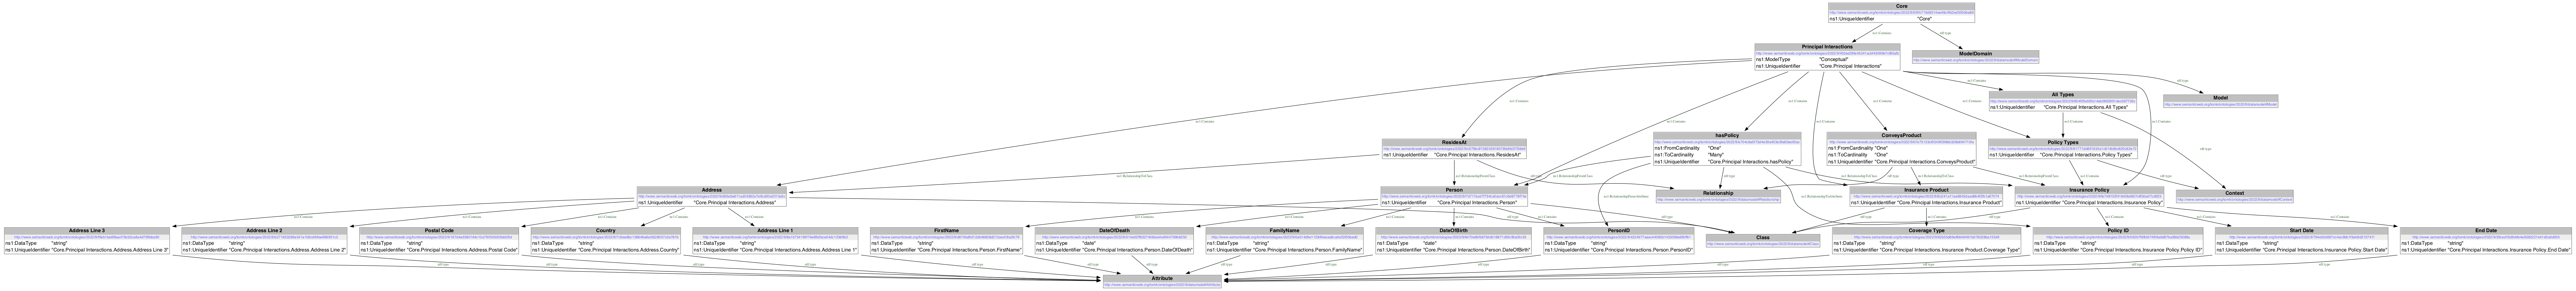

In [37]:
# Get entities listed that will participate in the final diagram
q_a = """
SELECT ?digest
                        WHERE 
                            {
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }

"""

results = qtest.query(q_a, initBindings={"batch_node": b_n[0]})
batch_triples = [discourse.longform_to_triple(r[0]) for r in results]
batch_graph = t2rdflibg(batch_triples)
visualize(batch_graph)

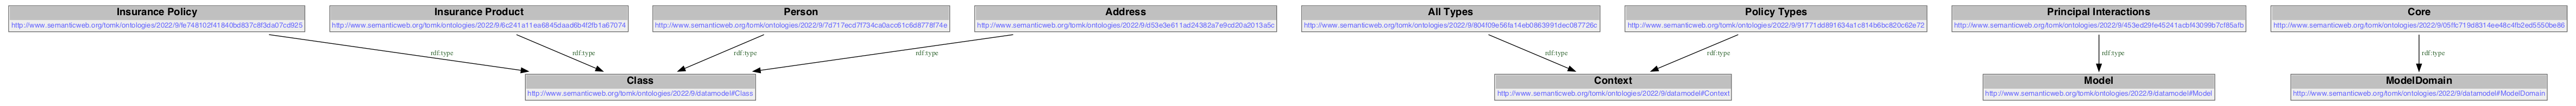

In [38]:
batch_graph.bind('dm', dmns, override=True, replace=True)
discns = Namespace(discourse.onto.base_iri)
batch_graph.bind('disc', discns, override=True, replace=True)

b_entities = """
SELECT ?s ?p ?o
WHERE{
    {
    VALUES ?ent_types { dm:ModelDomain dm:Model dm:Class dm:Context  } 
    VALUES ?p { rdf:type rdfs:label }
    ?s a ?ent_types.
    ?s ?p ?o.
    }

}
"""

b_entities_results = batch_graph.query(b_entities)
#for t in list(b_entities_results):
#    print(t)
ent_graph = t2rdflibg(b_entities_results)
visualize(ent_graph)

In [111]:
# Construct a dataframe of entities, we'll be using these to construct a graph containing these as nodes. 
ents_df = pd.DataFrame(b_entities_results, columns=['s','p','o']).sort_values(by='s')#.groupby(1)
ents_df = ents_df.pivot(index='s', columns='p')#.reset_index()
ents_df
flat_cols = ['_'.join(col).split("#")[1] for col in ents_df.columns.values]
ents_df.columns=flat_cols
ents_df['type']=ents_df['type'].apply(lambda x : x.split("#")[1])
ents_df=ents_df.sort_values(by='type')
#ents_df.columns
ents_df = ents_df[ents_df['type']=="Class"]
print(ents_df.reset_index()[['type','label']])

    type              label
0  Class  Insurance Product
1  Class             Person
2  Class            Address
3  Class   Insurance Policy


In [112]:
b_rels = """
SELECT ?from ?froml ?rel ?to ?tol ?rel_from_card ?rel_to_card
WHERE{
    {
        ?from ^dm:RelationshipFromClass/dm:RelationshipToClass  ?to .
        ?from rdfs:label ?froml.
        ?to rdfs:label ?tol.
        ?r dm:RelationshipToClass ?to.
        ?r rdfs:label ?rel .
        ?r a dm:Relationship .
        BIND (?rel as ?p)
        OPTIONAL {?r dm:ToCardinality ?rel_to_card}
        OPTIONAL {?r dm:FromCardinality ?rel_from_card}
    }

}
"""

b_rels_results = batch_graph.query(b_rels)
b_rels_df = pd.DataFrame(b_rels_results, columns=["from", "froml", "rel", "to", "tol", "fromcard", "tocard"])
print(b_rels_df[['froml','tol','rel','fromcard','tocard']])
#list(b_rels_results)

              froml                tol             rel fromcard tocard
0  Insurance Policy  Insurance Product  ConveysProduct      One    One
1            Person   Insurance Policy       hasPolicy      One   Many
2            Person            Address       ResidesAt     None   None


In [179]:
pdp_graph = pydotplus.graphviz.Dot(graph_name="pdp_graph", graph_type='digraph', prog="dot")
for i,e in b_rels_df.iterrows():
#    edge = pydotplus.graphviz.Edge(src=e['from'], dst=e['to'], set_label=e.name, set_fromcard=e['fromcard'], set_tocard=e['tocard'])
    edge = pydotplus.graphviz.Edge(src=e['froml'], dst=e['tol'], label=e['rel'])#, set_fromcard=e['fromcard'], set_tocard=e['tocard'])
    pdp_graph.add_edge(edge)
    
for i,n in ents_df.iterrows():
#    node = pydotplus.graphviz.Node(name=n.name, set_type=n['type'], set_label=n['label'])
    node = pydotplus.graphviz.Node(name=n['label'], type=n['type'], label=n['label'], width=2.0, fixedsize=False)
    pdp_graph.add_node(node)

pdp_graph

In [180]:
[n.get_pos() for n in pdp_graph.get_nodes()]

[None, None, None, None]

In [181]:
dot_code = pdp_graph.create_dot().decode()
print(dot_code)
gg=pydotplus.graphviz.graph_from_dot_data(dot_code)

digraph pdp_graph {
	graph [bb="0,0,310.69,210",
		prog=dot
	];
	node [label="\N"];
	"Insurance Policy"	 [fixedsize=False,
		height=0.5,
		label="Insurance Policy",
		pos="76.693,105",
		type=Class,
		width=2];
	"Insurance Product"	 [fixedsize=False,
		height=0.5,
		label="Insurance Product",
		pos="76.693,18",
		type=Class,
		width=2.1304];
	"Insurance Policy" -> "Insurance Product"	 [label=ConveysProduct,
		lp="123.19,61.5",
		pos="e,76.693,36.003 76.693,86.974 76.693,75.192 76.693,59.561 76.693,46.158"];
	Person	 [fixedsize=False,
		height=0.5,
		label=Person,
		pos="178.69,192",
		type=Class,
		width=2];
	Person -> "Insurance Policy"	 [label=hasPolicy,
		lp="162.19,148.5",
		pos="e,96.956,122.28 158.05,174.39 142.74,161.34 121.7,143.39 104.85,129.01"];
	Address	 [fixedsize=False,
		height=0.5,
		label=Address,
		pos="238.69,105",
		type=Class,
		width=2];
	Person -> Address	 [label=ResidesAt,
		lp="240.69,148.5",
		pos="e,226.28,123 191.13,173.97 199.57,161.73 210.89,145.32 220.36,

In [182]:
[(n.get_label(),  n.get_pos()) for n in gg.get_nodes()]

[('"\\N"', None),
 ('"\\N"', None),
 ('"Insurance Policy"', '"76.693,105"'),
 ('"Insurance Product"', '"76.693,18"'),
 ('Person', '"178.69,192"'),
 ('Address', '"238.69,105"')]

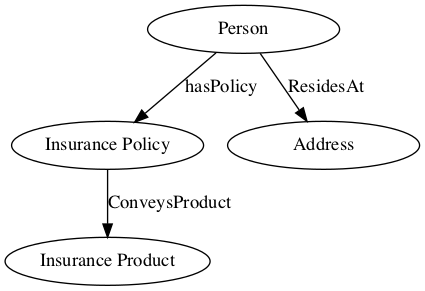

In [183]:
png=gg.create_png()
display(Image(png))

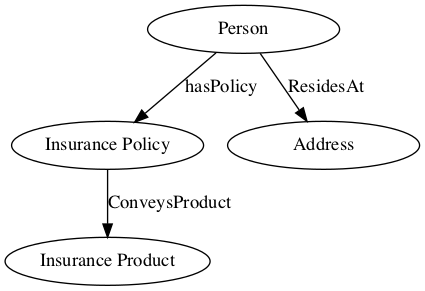

In [184]:
png=pdp_graph.create_png()
display(Image(png))